# 🔬 Objective Calibration Analysis

## School Suspension Prediction - Unbiased Calibration Study

**Objective**: Test all calibration methods and report results objectively.

**No composite scores. No winners. Just facts and tradeoffs.**

---

### Critical Understanding

- **Temperature T < 1**: Sharpens predictions (increases confidence, widens separation)
- **Temperature T > 1**: Smooths predictions (decreases confidence, narrows separation)  
- **Calibration often trades discrimination for accuracy**
- **Class imbalance (2.13%)** makes perfect calibration nearly impossible

---

### What This Notebook Does

1. Tests 8+ calibration methods (Temperature scaling, Platt, Isotonic, Beta)
2. Reports ALL metrics without weighting or ranking
3. Shows clear tradeoffs between calibration, discrimination, and detection
4. Tests on weather scenarios
5. **Makes NO recommendations** - you decide based on your priorities

---
## 📦 Section 1: Setup and Imports

In [37]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from pathlib import Path
from datetime import date
import warnings
warnings.filterwarnings('ignore')

# ML metrics
from sklearn.metrics import (
    confusion_matrix, classification_report,
    precision_score, recall_score, f1_score, fbeta_score,
    roc_auc_score, average_precision_score,
    brier_score_loss, log_loss
)
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Setup paths
DATA_DIR = Path('../data')
PROCESSED_DIR = DATA_DIR / 'processed'
RESULTS_DIR = PROCESSED_DIR / 'calibration_results_objective'
RESULTS_DIR.mkdir(exist_ok=True)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("="*80)
print("OBJECTIVE CALIBRATION ANALYSIS")
print("="*80)

OBJECTIVE CALIBRATION ANALYSIS


---
## 📂 Section 2: Load Model and Data

In [38]:
print("="*80)
print("LOADING MODEL AND DATA")
print("="*80)

# Load model
model = joblib.load(PROCESSED_DIR / 'best_core_model.pkl')
print(f"\nModel: {type(model).__name__}")

# Load metadata
with open(PROCESSED_DIR / 'core_model_metadata.json', 'r') as f:
    metadata = json.load(f)

print(f"\nValidation Performance:")
print(f"  F2: {metadata['best_f2']:.4f}")
print(f"  Recall: {metadata['best_recall']:.4f}")
print(f"  Precision: {metadata['best_precision']:.4f}")

# Load data
train_df = pd.read_csv(PROCESSED_DIR / 'master_train.csv')
val_df = pd.read_csv(PROCESSED_DIR / 'master_validation.csv')
test_df = pd.read_csv(PROCESSED_DIR / 'master_test.csv')

print(f"\nData:")
print(f"  Training: {len(train_df):,} ({train_df['suspension_occurred'].sum()} suspensions, {train_df['suspension_occurred'].mean():.2%})")
print(f"  Validation: {len(val_df):,} ({val_df['suspension_occurred'].sum()} suspensions, {val_df['suspension_occurred'].mean():.2%})")
print(f"  Test: {len(test_df):,} ({test_df['suspension_occurred'].sum()} suspensions, {test_df['suspension_occurred'].mean():.2%})")

FEATURE_ORDER = metadata['selected_features']

LOADING MODEL AND DATA

Model: EasyEnsembleClassifier

Validation Performance:
  F2: 0.5525
  Recall: 0.6020
  Precision: 0.4158

Data:
  Training: 11,033 (110 suspensions, 1.00%)
  Validation: 3,111 (201 suspensions, 6.46%)
  Test: 4,556 (97 suspensions, 2.13%)


In [39]:
# Generate predictions
print("\nGenerating predictions...")

X_train = train_df[FEATURE_ORDER]
y_train = train_df['suspension_occurred']
train_probs = model.predict_proba(X_train)[:, 1]

X_val = val_df[FEATURE_ORDER]
y_val = val_df['suspension_occurred']
val_probs = model.predict_proba(X_val)[:, 1]

X_test = test_df[FEATURE_ORDER]
y_test = test_df['suspension_occurred']
test_probs = model.predict_proba(X_test)[:, 1]

# Split training data for calibration fitting
X_cal, X_calib_test, y_cal, y_calib_test = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)
cal_probs = model.predict_proba(X_cal)[:, 1]
calib_test_probs = model.predict_proba(X_calib_test)[:, 1]

print(f"\nCalibration split:")
print(f"  Fitting: {len(X_cal):,} ({y_cal.sum()} suspensions)")
print(f"  Testing: {len(X_calib_test):,} ({y_calib_test.sum()} suspensions)")


Generating predictions...

Calibration split:
  Fitting: 8,826 (88 suspensions)
  Testing: 2,207 (22 suspensions)


---
## 📊 Section 3: Define Metrics (No Weighting)

In [40]:
def compute_all_metrics(y_true, y_proba, threshold=0.5):
    """
    Compute all metrics without weighting or combining them.
    Returns a dictionary of individual metrics.
    """
    y_pred = (y_proba >= threshold).astype(int)
    
    # Classification
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    recall = recall_score(y_true, y_pred, zero_division=0)
    precision = precision_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    f2 = fbeta_score(y_true, y_pred, beta=2, zero_division=0)
    
    # Probabilistic
    roc_auc = roc_auc_score(y_true, y_proba)
    pr_auc = average_precision_score(y_true, y_proba)
    brier = brier_score_loss(y_true, y_proba)
    logloss = log_loss(y_true, y_proba)
    
    # Calibration - ECE
    n_bins = 10
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(y_proba, bin_edges[:-1]) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    
    ece = 0
    for i in range(n_bins):
        mask = bin_indices == i
        if mask.sum() > 0:
            bin_acc = y_true[mask].mean()
            bin_conf = y_proba[mask].mean()
            bin_weight = mask.sum() / len(y_proba)
            ece += bin_weight * abs(bin_acc - bin_conf)
    
    # Discrimination - class separation
    suspended_probs = y_proba[y_true == 1]
    no_susp_probs = y_proba[y_true == 0]
    
    if len(suspended_probs) > 0 and len(no_susp_probs) > 0:
        separation = suspended_probs.mean() - no_susp_probs.mean()
        suspended_mean = suspended_probs.mean()
        no_susp_mean = no_susp_probs.mean()
    else:
        separation = 0
        suspended_mean = 0
        no_susp_mean = 0
    
    # Sharpness
    sharpness_std = y_proba.std()
    
    return {
        'TP': int(tp), 'TN': int(tn), 'FP': int(fp), 'FN': int(fn),
        'Recall': recall,
        'Precision': precision,
        'F1': f1,
        'F2': f2,
        'ROC_AUC': roc_auc,
        'PR_AUC': pr_auc,
        'Brier': brier,
        'LogLoss': logloss,
        'ECE': ece,
        'Separation': separation,
        'Susp_Mean_Prob': suspended_mean,
        'NoSusp_Mean_Prob': no_susp_mean,
        'Sharpness_Std': sharpness_std,
        'Prob_Min': y_proba.min(),
        'Prob_Max': y_proba.max(),
    }

print("✅ Metrics function defined")

✅ Metrics function defined


---
## 📈 Section 4: Baseline (Uncalibrated) Performance

In [41]:
print("="*80)
print("BASELINE (UNCALIBRATED) PERFORMANCE")
print("="*80)

baseline_test = compute_all_metrics(y_test, test_probs)

print("\nTest Set Performance:")
print(f"  Recall: {baseline_test['Recall']:.4f} ({baseline_test['TP']}/{baseline_test['TP']+baseline_test['FN']} suspensions detected)")
print(f"  Precision: {baseline_test['Precision']:.4f} ({baseline_test['TP']}/{baseline_test['TP']+baseline_test['FP']} predictions correct)")
print(f"  F2: {baseline_test['F2']:.4f}")
print(f"\n  ECE: {baseline_test['ECE']:.4f} (target: <0.10)")
print(f"  Brier: {baseline_test['Brier']:.4f}")
print(f"  Log Loss: {baseline_test['LogLoss']:.4f}")
print(f"\n  Class Separation: {baseline_test['Separation']:.4f} ({baseline_test['Separation']*100:.1f}%)")
print(f"    Suspended mean prob: {baseline_test['Susp_Mean_Prob']:.4f}")
print(f"    No-susp mean prob: {baseline_test['NoSusp_Mean_Prob']:.4f}")
print(f"  Sharpness (std): {baseline_test['Sharpness_Std']:.4f}")
print(f"  Probability range: {baseline_test['Prob_Min']:.4f} - {baseline_test['Prob_Max']:.4f}")

BASELINE (UNCALIBRATED) PERFORMANCE

Test Set Performance:
  Recall: 0.9794 (95/97 suspensions detected)
  Precision: 0.2169 (95/438 predictions correct)
  F2: 0.5751

  ECE: 0.3351 (target: <0.10)
  Brier: 0.1333
  Log Loss: 0.4472

  Class Separation: 0.2376 (23.8%)
    Suspended mean prob: 0.5890
    No-susp mean prob: 0.3514
  Sharpness (std): 0.1003
  Probability range: 0.2094 - 0.6979


---
## 🔧 Section 5: Calibration Methods

### Understanding Temperature Scaling

- **T < 1** (e.g., 0.5): Divides logits by number < 1 = multiplies logits → **SHARPENS** (more extreme probabilities)
- **T = 1**: No change (original model)
- **T > 1** (e.g., 2.0): Divides logits by number > 1 → **SMOOTHS** (less extreme probabilities)

**For overconfident models, use T > 1 to smooth, NOT T < 1 which sharpens further.**

In [42]:
print("="*80)
print("TESTING CALIBRATION METHODS")
print("="*80)

calibration_methods = {}

# --- Temperature Scaling ---
print("\n(a) Temperature Scaling")
print("    T < 1: Sharpens (increases separation, may worsen calibration)")
print("    T > 1: Smooths (decreases separation, may improve calibration)")

def temperature_scaling(probs, T):
    """Apply temperature scaling."""
    epsilon = 1e-7
    probs_clipped = np.clip(probs, epsilon, 1 - epsilon)
    logits = np.log(probs_clipped / (1 - probs_clipped))
    scaled_logits = logits / T
    return 1 / (1 + np.exp(-scaled_logits))

for T in [0.5, 1.0, 1.5, 2.0, 3.0, 4.0]:
    method_name = f"Temp_T{T:.1f}".replace('.', '_')
    calibration_methods[method_name] = {
        'name': f"Temperature T={T}",
        'description': f"{'Sharpening' if T < 1 else 'Neutral' if T == 1 else 'Smoothing'} (T={T})",
        'test_probs': temperature_scaling(test_probs, T),
        'val_probs': temperature_scaling(val_probs, T),
        'calib_test_probs': temperature_scaling(calib_test_probs, T),
    }
    print(f"    T={T}: {calibration_methods[method_name]['description']}")

print(f"\n  ✅ Temperature scaling: {len([k for k in calibration_methods if 'Temp' in k])} variants")

TESTING CALIBRATION METHODS

(a) Temperature Scaling
    T < 1: Sharpens (increases separation, may worsen calibration)
    T > 1: Smooths (decreases separation, may improve calibration)
    T=0.5: Sharpening (T=0.5)
    T=1.0: Neutral (T=1.0)
    T=1.5: Smoothing (T=1.5)
    T=2.0: Smoothing (T=2.0)
    T=3.0: Smoothing (T=3.0)
    T=4.0: Smoothing (T=4.0)

  ✅ Temperature scaling: 6 variants


In [43]:
# --- Platt Scaling ---
print("\n(b) Platt Scaling (Logistic Regression)")
print("    Fits sigmoid to map probabilities to calibrated values")

platt_scaler = LogisticRegression()
platt_scaler.fit(cal_probs.reshape(-1, 1), y_cal)

calibration_methods['Platt'] = {
    'name': "Platt Scaling",
    'description': "Parametric sigmoid calibration",
    'test_probs': platt_scaler.predict_proba(test_probs.reshape(-1, 1))[:, 1],
    'val_probs': platt_scaler.predict_proba(val_probs.reshape(-1, 1))[:, 1],
    'calib_test_probs': platt_scaler.predict_proba(calib_test_probs.reshape(-1, 1))[:, 1],
}
print("    ✅ Fitted on calibration set")


(b) Platt Scaling (Logistic Regression)
    Fits sigmoid to map probabilities to calibrated values
    ✅ Fitted on calibration set


In [44]:
# --- Isotonic Regression ---
print("\n(c) Isotonic Regression")
print("    Non-parametric monotonic calibration")

isotonic = IsotonicRegression(out_of_bounds='clip')
isotonic.fit(cal_probs, y_cal)

calibration_methods['Isotonic'] = {
    'name': "Isotonic Regression",
    'description': "Non-parametric monotonic calibration",
    'test_probs': isotonic.predict(test_probs),
    'val_probs': isotonic.predict(val_probs),
    'calib_test_probs': isotonic.predict(calib_test_probs),
}
print("    ✅ Fitted on calibration set")


(c) Isotonic Regression
    Non-parametric monotonic calibration
    ✅ Fitted on calibration set


In [45]:
# --- Beta Calibration (if available) ---
try:
    from betacal import BetaCalibration
    
    print("\n(d) Beta Calibration")
    print("    Non-uniform correction with Beta distribution")
    
    beta_cal = BetaCalibration(parameters="abm")
    beta_cal.fit(cal_probs, y_cal)
    
    calibration_methods['Beta'] = {
        'name': "Beta Calibration",
        'description': "Beta distribution-based calibration",
        'test_probs': beta_cal.predict(test_probs),
        'val_probs': beta_cal.predict(val_probs),
        'calib_test_probs': beta_cal.predict(calib_test_probs),
    }
    print("    ✅ Fitted on calibration set")
except ImportError:
    print("\n(d) Beta Calibration: ⚠️ Not available (install betacal package)")


(d) Beta Calibration
    Non-uniform correction with Beta distribution
    ✅ Fitted on calibration set


In [46]:
# --- Uncalibrated baseline ---
calibration_methods['Uncalibrated'] = {
    'name': "Uncalibrated",
    'description': "Original model predictions",
    'test_probs': test_probs,
    'val_probs': val_probs,
    'calib_test_probs': calib_test_probs,
}

print(f"\n\n📊 Total methods ready: {len(calibration_methods)}")



📊 Total methods ready: 10


---
## 📋 Section 6: Evaluate All Methods on Test Set

In [47]:
print("="*80)
print("RESULTS: ALL METHODS ON TEST SET")
print("="*80)

results = []

for method_key, method_data in calibration_methods.items():
    metrics = compute_all_metrics(y_test, method_data['test_probs'])
    metrics['Method'] = method_data['name']
    metrics['Method_Key'] = method_key
    metrics['Description'] = method_data['description']
    results.append(metrics)

results_df = pd.DataFrame(results)

# Save full results
results_df.to_csv(RESULTS_DIR / 'calibration_results_all_methods.csv', index=False)
print(f"\n✅ Saved: {RESULTS_DIR / 'calibration_results_all_methods.csv'}")

RESULTS: ALL METHODS ON TEST SET

✅ Saved: ..\data\processed\calibration_results_objective\calibration_results_all_methods.csv


In [48]:
# Display results table
print("\nPerformance Metrics:")
print("-" * 120)
print(f"{'Method':<25} {'ECE':>8} {'Brier':>8} {'Sep':>8} {'Sharp':>8} {'F2':>8} {'Recall':>8} {'Prec':>8}")
print("-" * 120)

for _, row in results_df.iterrows():
    print(f"{row['Method']:<25} "
          f"{row['ECE']:>8.4f} "
          f"{row['Brier']:>8.4f} "
          f"{row['Separation']:>8.4f} "
          f"{row['Sharpness_Std']:>8.4f} "
          f"{row['F2']:>8.4f} "
          f"{row['Recall']:>8.4f} "
          f"{row['Precision']:>8.4f}")

print("-" * 120)


Performance Metrics:
------------------------------------------------------------------------------------------------------------------------
Method                         ECE    Brier      Sep    Sharp       F2   Recall     Prec
------------------------------------------------------------------------------------------------------------------------
Temperature T=0.5           0.2330   0.0852   0.4221   0.1663   0.5751   0.9794   0.2169
Temperature T=1.0           0.3351   0.1333   0.2376   0.1003   0.5751   0.9794   0.2169
Temperature T=1.5           0.3796   0.1630   0.1626   0.0699   0.5751   0.9794   0.2169
Temperature T=2.0           0.4034   0.1813   0.1232   0.0533   0.5751   0.9794   0.2169
Temperature T=3.0           0.4280   0.2019   0.0827   0.0360   0.5751   0.9794   0.2169
Temperature T=4.0           0.4406   0.2131   0.0622   0.0271   0.5751   0.9794   0.2169
Platt Scaling               0.0070   0.0182   0.0881   0.0308   0.0000   0.0000   0.0000
Isotonic Regression     

---
## 🔍 Section 7: Comparative Analysis

In [49]:
print("="*80)
print("COMPARATIVE ANALYSIS")
print("="*80)

uncal = results_df[results_df['Method_Key'] == 'Uncalibrated'].iloc[0]

print("\n(a) Best ECE (Calibration Accuracy):")
best_ece = results_df.nsmallest(3, 'ECE')
for i, (_, row) in enumerate(best_ece.iterrows(), 1):
    change = row['ECE'] - uncal['ECE']
    print(f"  {i}. {row['Method']:<25} ECE: {row['ECE']:.4f} ({change:+.4f} vs uncal)")

print("\n(b) Best Separation (Class Discrimination):")
best_sep = results_df.nlargest(3, 'Separation')
for i, (_, row) in enumerate(best_sep.iterrows(), 1):
    change = row['Separation'] - uncal['Separation']
    print(f"  {i}. {row['Method']:<25} Sep: {row['Separation']:.4f} ({change:+.4f} vs uncal)")

print("\n(c) Best F2 (Detection Performance):")
best_f2 = results_df.nlargest(3, 'F2')
for i, (_, row) in enumerate(best_f2.iterrows(), 1):
    change = row['F2'] - uncal['F2']
    print(f"  {i}. {row['Method']:<25} F2: {row['F2']:.4f} ({change:+.4f} vs uncal)")

print("\n(d) Best Sharpness (Probability Spread):")
best_sharp = results_df.nlargest(3, 'Sharpness_Std')
for i, (_, row) in enumerate(best_sharp.iterrows(), 1):
    change = row['Sharpness_Std'] - uncal['Sharpness_Std']
    print(f"  {i}. {row['Method']:<25} Sharp: {row['Sharpness_Std']:.4f} ({change:+.4f} vs uncal)")

COMPARATIVE ANALYSIS

(a) Best ECE (Calibration Accuracy):
  1. Platt Scaling             ECE: 0.0070 (-0.3281 vs uncal)
  2. Beta Calibration          ECE: 0.0198 (-0.3153 vs uncal)
  3. Isotonic Regression       ECE: 0.0206 (-0.3145 vs uncal)

(b) Best Separation (Class Discrimination):
  1. Temperature T=0.5         Sep: 0.4221 (+0.1845 vs uncal)
  2. Temperature T=1.0         Sep: 0.2376 (+0.0000 vs uncal)
  3. Uncalibrated              Sep: 0.2376 (+0.0000 vs uncal)

(c) Best F2 (Detection Performance):
  1. Temperature T=0.5         F2: 0.5751 (+0.0000 vs uncal)
  2. Temperature T=1.0         F2: 0.5751 (+0.0000 vs uncal)
  3. Temperature T=1.5         F2: 0.5751 (+0.0000 vs uncal)

(d) Best Sharpness (Probability Spread):
  1. Temperature T=0.5         Sharp: 0.1663 (+0.0660 vs uncal)
  2. Temperature T=1.0         Sharp: 0.1003 (+0.0000 vs uncal)
  3. Uncalibrated              Sharp: 0.1003 (+0.0000 vs uncal)


---
## ⚖️ Section 8: Tradeoff Analysis

In [50]:
print("="*80)
print("TRADEOFF ANALYSIS: CALIBRATION vs DISCRIMINATION")
print("="*80)

print("\n✅ ECE < 0.10 methods (good calibration):")
good_cal = results_df[results_df['ECE'] < 0.10].sort_values('ECE')
if len(good_cal) > 0:
    for _, row in good_cal.iterrows():
        print(f"  {row['Method']:<25} ECE: {row['ECE']:.4f}, Sep: {row['Separation']:.4f}, F2: {row['F2']:.4f}")
else:
    print("  None found (all methods have ECE >= 0.10)")

print("\n✅ Separation > 0.25 methods (good discrimination):")
good_sep = results_df[results_df['Separation'] > 0.25].sort_values('Separation', ascending=False)
if len(good_sep) > 0:
    for _, row in good_sep.iterrows():
        print(f"  {row['Method']:<25} Sep: {row['Separation']:.4f}, ECE: {row['ECE']:.4f}, F2: {row['F2']:.4f}")
else:
    print("  None found (all methods have separation < 0.25)")

print("\n✅ F2 > 0.55 methods (good detection):")
good_f2 = results_df[results_df['F2'] > 0.55].sort_values('F2', ascending=False)
if len(good_f2) > 0:
    for _, row in good_f2.iterrows():
        print(f"  {row['Method']:<25} F2: {row['F2']:.4f}, ECE: {row['ECE']:.4f}, Sep: {row['Separation']:.4f}")
else:
    print("  None found (all methods have F2 < 0.55)")

print("\n🎯 Methods meeting ALL criteria (ECE<0.10, Sep>0.25, F2>0.55):")
all_good = results_df[(results_df['ECE'] < 0.10) & 
                      (results_df['Separation'] > 0.25) & 
                      (results_df['F2'] > 0.55)]
if len(all_good) > 0:
    for _, row in all_good.iterrows():
        print(f"  {row['Method']}")
else:
    print("  ❌ None (impossible with this class imbalance)")

TRADEOFF ANALYSIS: CALIBRATION vs DISCRIMINATION

✅ ECE < 0.10 methods (good calibration):
  Platt Scaling             ECE: 0.0070, Sep: 0.0881, F2: 0.0000
  Beta Calibration          ECE: 0.0198, Sep: 0.1888, F2: 0.1598
  Isotonic Regression       ECE: 0.0206, Sep: 0.1576, F2: 0.1595

✅ Separation > 0.25 methods (good discrimination):
  Temperature T=0.5         Sep: 0.4221, ECE: 0.2330, F2: 0.5751

✅ F2 > 0.55 methods (good detection):
  Temperature T=0.5         F2: 0.5751, ECE: 0.2330, Sep: 0.4221
  Temperature T=1.0         F2: 0.5751, ECE: 0.3351, Sep: 0.2376
  Temperature T=1.5         F2: 0.5751, ECE: 0.3796, Sep: 0.1626
  Temperature T=2.0         F2: 0.5751, ECE: 0.4034, Sep: 0.1232
  Temperature T=3.0         F2: 0.5751, ECE: 0.4280, Sep: 0.0827
  Temperature T=4.0         F2: 0.5751, ECE: 0.4406, Sep: 0.0622
  Uncalibrated              F2: 0.5751, ECE: 0.3351, Sep: 0.2376

🎯 Methods meeting ALL criteria (ECE<0.10, Sep>0.25, F2>0.55):
  ❌ None (impossible with this class imb

---
## 📊 Section 9: Visualizations

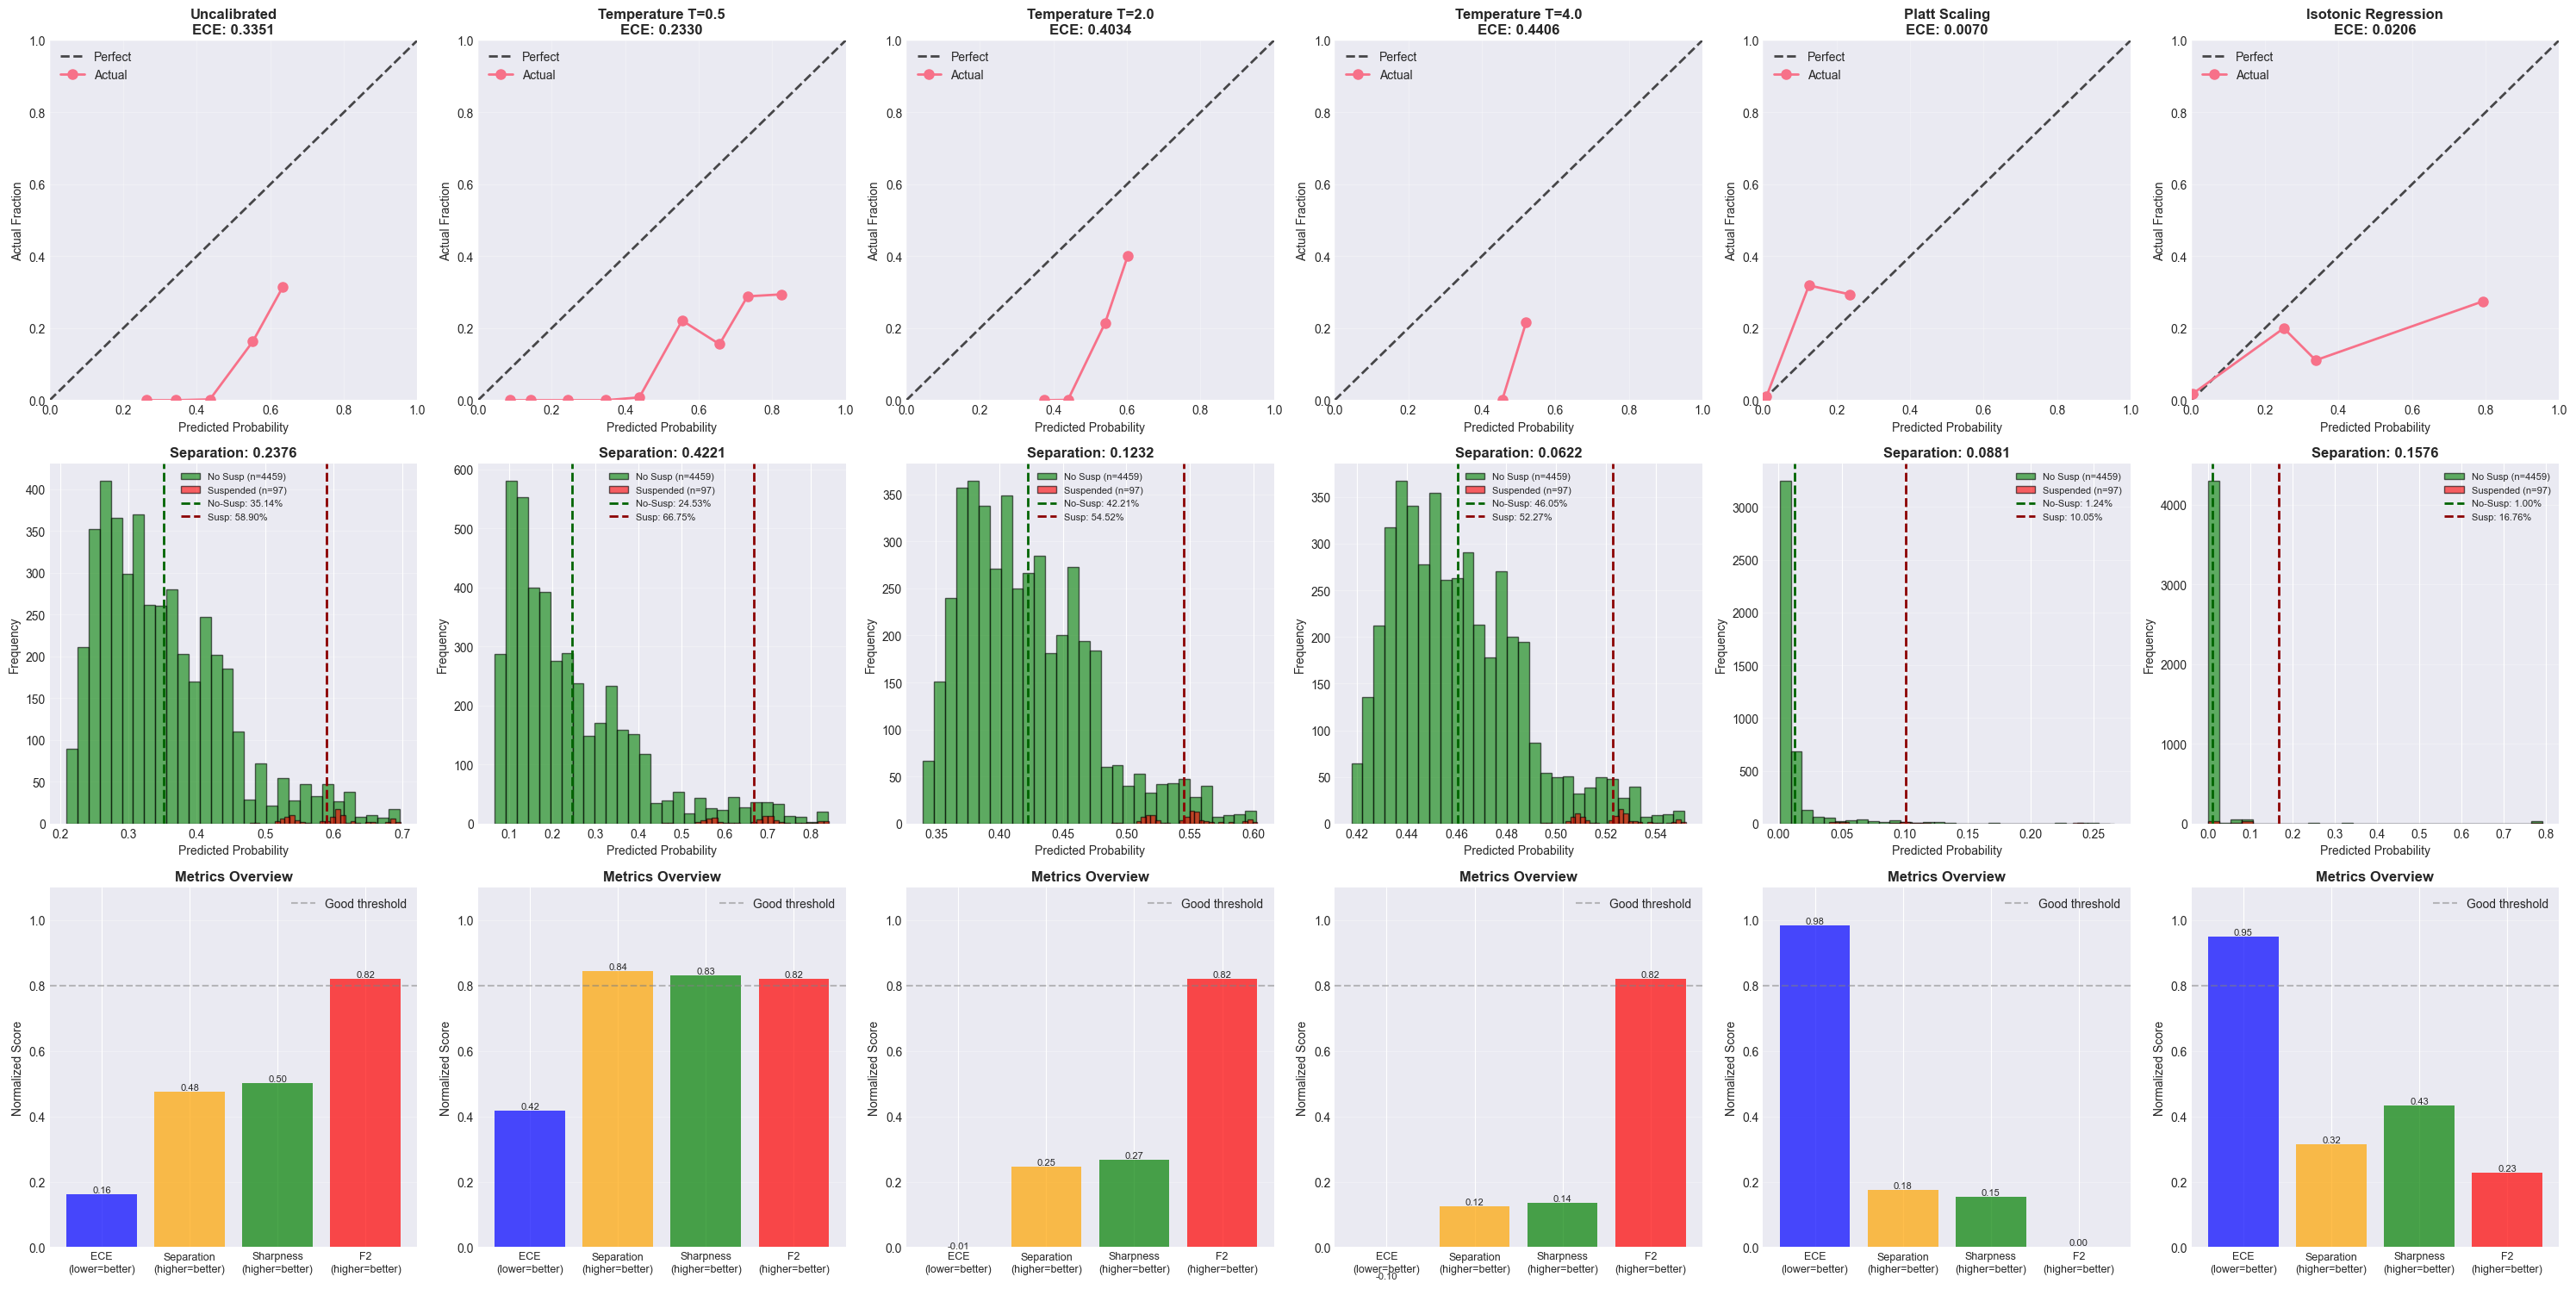

✅ Saved: calibration_comparison_all_methods.png


In [51]:
# Select key methods for visualization
viz_methods = ['Uncalibrated', 'Temp_T0_5', 'Temp_T2_0', 'Temp_T4_0', 'Platt', 'Isotonic']
viz_methods = [m for m in viz_methods if m in calibration_methods]

fig, axes = plt.subplots(3, len(viz_methods), figsize=(5*len(viz_methods), 15))

for idx, method_key in enumerate(viz_methods):
    method_data = calibration_methods[method_key]
    method_probs = method_data['test_probs']
    method_metrics = results_df[results_df['Method_Key'] == method_key].iloc[0]
    
    # Row 1: Calibration Curve
    ax = axes[0, idx]
    fraction_pos, mean_pred = calibration_curve(y_test, method_probs, n_bins=10, strategy='uniform')
    ax.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.7, label='Perfect')
    ax.plot(mean_pred, fraction_pos, 'o-', lw=2, markersize=8, label='Actual')
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Actual Fraction')
    ax.set_title(f"{method_data['name']}\nECE: {method_metrics['ECE']:.4f}", fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    
    # Row 2: Probability Distribution
    ax = axes[1, idx]
    suspended_probs = method_probs[y_test == 1]
    no_susp_probs = method_probs[y_test == 0]
    
    ax.hist(no_susp_probs, bins=30, alpha=0.6, color='green', 
            edgecolor='black', label=f'No Susp (n={len(no_susp_probs)})')
    ax.hist(suspended_probs, bins=30, alpha=0.6, color='red', 
            edgecolor='black', label=f'Suspended (n={len(suspended_probs)})')
    ax.axvline(method_metrics['NoSusp_Mean_Prob'], color='darkgreen', 
               linestyle='--', linewidth=2, label=f"No-Susp: {method_metrics['NoSusp_Mean_Prob']:.2%}")
    ax.axvline(method_metrics['Susp_Mean_Prob'], color='darkred', 
               linestyle='--', linewidth=2, label=f"Susp: {method_metrics['Susp_Mean_Prob']:.2%}")
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Frequency')
    ax.set_title(f"Separation: {method_metrics['Separation']:.4f}", fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Row 3: Metrics Comparison
    ax = axes[2, idx]
    
    metrics_to_plot = {
        'ECE\n(lower=better)': method_metrics['ECE'] / 0.40,
        'Separation\n(higher=better)': method_metrics['Separation'] / 0.50,
        'Sharpness\n(higher=better)': method_metrics['Sharpness_Std'] / 0.20,
        'F2\n(higher=better)': method_metrics['F2'] / 0.70,
    }
    
    # Invert ECE for plotting (so up = good)
    metrics_to_plot['ECE\n(lower=better)'] = 1 - metrics_to_plot['ECE\n(lower=better)']
    
    labels = list(metrics_to_plot.keys())
    values = list(metrics_to_plot.values())
    
    bars = ax.bar(range(len(labels)), values, alpha=0.7, 
                   color=['blue', 'orange', 'green', 'red'])
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, fontsize=9)
    ax.set_ylabel('Normalized Score')
    ax.set_title('Metrics Overview', fontweight='bold')
    ax.set_ylim([0, 1.1])
    ax.axhline(y=0.8, color='gray', linestyle='--', alpha=0.5, label='Good threshold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.legend()
    
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.2f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'calibration_comparison_all_methods.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved: calibration_comparison_all_methods.png")

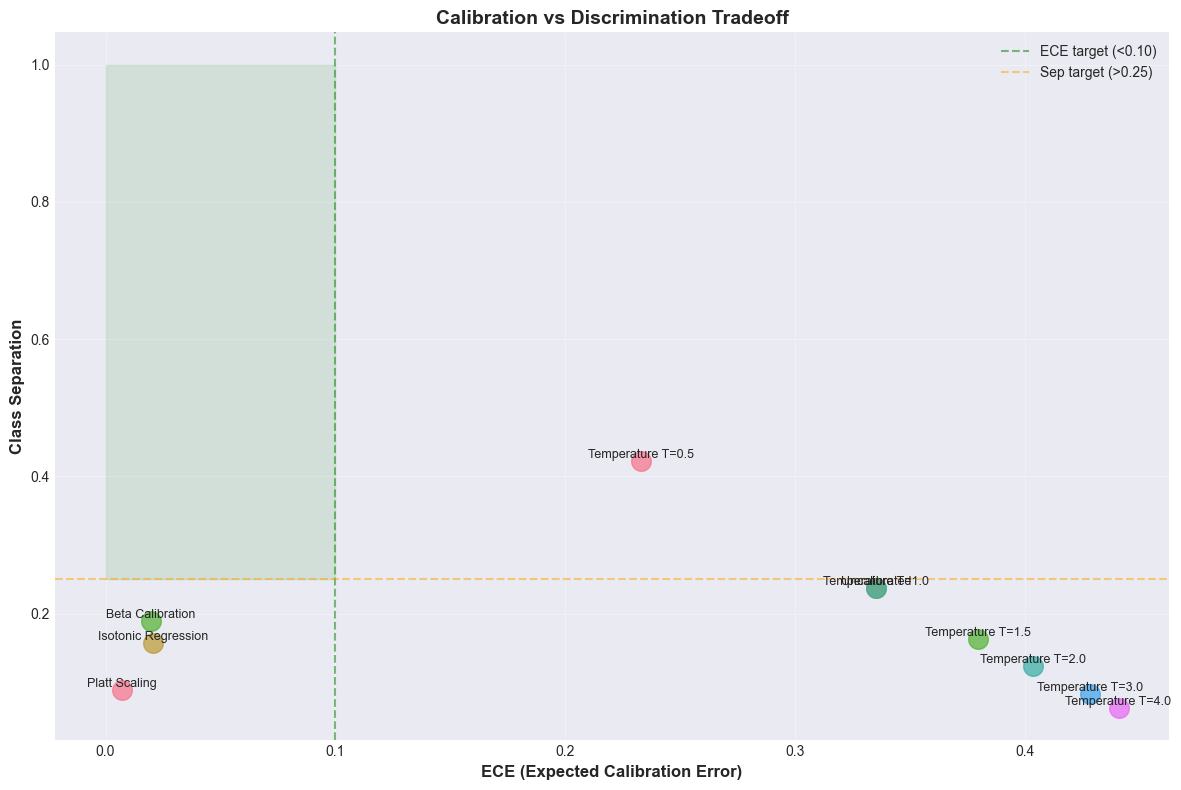

✅ Saved: calibration_tradeoff_scatter.png


In [52]:
# Scatter plot: ECE vs Separation tradeoff
fig, ax = plt.subplots(figsize=(12, 8))

for _, row in results_df.iterrows():
    ax.scatter(row['ECE'], row['Separation'], s=200, alpha=0.7)
    ax.annotate(row['Method'], (row['ECE'], row['Separation']), 
                fontsize=9, ha='center', va='bottom')

ax.axvline(x=0.10, color='green', linestyle='--', alpha=0.5, label='ECE target (<0.10)')
ax.axhline(y=0.25, color='orange', linestyle='--', alpha=0.5, label='Sep target (>0.25)')

ax.set_xlabel('ECE (Expected Calibration Error)', fontsize=12, fontweight='bold')
ax.set_ylabel('Class Separation', fontsize=12, fontweight='bold')
ax.set_title('Calibration vs Discrimination Tradeoff', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Shade ideal region
ax.fill_between([0, 0.10], 0.25, 1, alpha=0.1, color='green', label='Ideal region')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'calibration_tradeoff_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved: calibration_tradeoff_scatter.png")

---
## 🌦️ Section 10: Weather Scenario Testing

In [53]:
print("="*80)
print("WEATHER SCENARIO TESTING")
print("="*80)

# Calculate weather statistics
weather_vars = [
    'fcst_precipitation_sum', 'fcst_wind_speed_max', 'fcst_wind_gusts_max',
    'fcst_temperature_max', 'fcst_relative_humidity_mean'
]

weather_stats = {}
for var in weather_vars:
    if var in train_df.columns:
        weather_stats[var] = {
            'min': train_df[var].min(),
            'p25': train_df[var].quantile(0.25),
            'p75': train_df[var].quantile(0.75),
            'p95': train_df[var].quantile(0.95),
            'max': train_df[var].max()
        }

scenarios = {
    'clear': {
        'name': 'Clear Weather',
        'expected': 0,
        'rain': 0.0,
        'wind': weather_stats['fcst_wind_speed_max']['min']
    },
    'heavy': {
        'name': 'Heavy Rain (p75)',
        'expected': '5-10',
        'rain': weather_stats['fcst_precipitation_sum']['p75'],
        'wind': weather_stats['fcst_wind_speed_max']['p75']
    },
    'extreme': {
        'name': 'Extreme (p95)',
        'expected': '12-15',
        'rain': weather_stats['fcst_precipitation_sum']['p95'],
        'wind': weather_stats['fcst_wind_speed_max']['p95']
    },
    'typhoon': {
        'name': 'Typhoon (max)',
        'expected': 17,
        'rain': weather_stats['fcst_precipitation_sum']['max'],
        'wind': weather_stats['fcst_wind_speed_max']['max']
    }
}

print("\nScenarios:")
for key, scenario in scenarios.items():
    print(f"  {scenario['name']}: {scenario['rain']:.1f}mm rain, {scenario['wind']:.1f}kph wind (expect {scenario['expected']} suspensions)")

WEATHER SCENARIO TESTING

Scenarios:
  Clear Weather: 0.0mm rain, 3.2kph wind (expect 0 suspensions)
  Heavy Rain (p75): 9.0mm rain, 14.4kph wind (expect 5-10 suspensions)
  Extreme (p95): 26.3mm rain, 23.4kph wind (expect 12-15 suspensions)
  Typhoon (max): 191.0mm rain, 66.6kph wind (expect 17 suspensions)


In [57]:
# Create scenario feature vectors
def create_scenario_features(rain, wind, lgu_id=0, test_date=date(2025, 11, 2)):
    """Create complete feature vector."""
    features = {
        'year': test_date.year,
        'month': test_date.month,
        'day': test_date.day,
        'day_of_week': test_date.weekday(),
        'is_rainy_season': 1 if test_date.month in [6,7,8,9,10,11] else 0,
        'month_from_sy_start': (test_date.month - 6) % 12,
        'is_holiday': 0,
        'is_school_day': 1,
        'lgu_id': lgu_id,
        'mean_flood_risk_score': 0.5,
        'fcst_precipitation_sum': rain,
        'fcst_wind_speed_max': wind,
        'fcst_wind_gusts_max': wind * 1.5,
        'fcst_temperature_max': 30.0,
        'fcst_relative_humidity_mean': 80.0,
        'hist_precipitation_sum_t1': rain * 0.5,
        'hist_wind_speed_max_t1': wind * 0.8,
    }
    
    # Add missing features with defaults
    for feat in FEATURE_ORDER:
        if feat not in features:
            features[feat] = 0
    
    return features

scenario_results = {}

for scenario_key, scenario in scenarios.items():
    # Create features for one representative LGU
    features = create_scenario_features(scenario['rain'], scenario['wind'])
    X_scenario = pd.DataFrame([features])[FEATURE_ORDER]
    
    # Get predictions from original model
    base_prob = model.predict_proba(X_scenario)[0, 1]
    
    scenario_results[scenario_key] = {
        'scenario': scenario['name'],
        'expected': scenario['expected'],
        'Uncalibrated': base_prob
    }
    
    # Apply each calibration method
    for method_key, method_data in calibration_methods.items():
        if method_key == 'Uncalibrated':
            continue
        
        # Apply calibration to base probability
        if method_key.startswith('Temp_T'):
            # Parse temperature from method_key like "Temp_T0_5" -> 0.5 or "Temp_T2_0" -> 2.0
            temp_part = method_key.replace('Temp_T', '')  # Get "0_5" or "2_0"
            temp_str = temp_part.replace('_', '.')  # Convert to "0.5" or "2.0"
            T = float(temp_str)
            cal_prob = temperature_scaling(np.array([base_prob]), T)[0]
        elif method_key == 'Platt':
            cal_prob = platt_scaler.predict_proba(np.array([[base_prob]]))[0, 1]
        elif method_key == 'Isotonic':
            cal_prob = isotonic.predict(np.array([base_prob]))[0]
        elif method_key == 'Beta':
            cal_prob = beta_cal.predict(np.array([base_prob]))[0]
        else:
            continue
        
        scenario_results[scenario_key][method_data['name']] = cal_prob

print("\n✅ Scenario predictions generated")


✅ Scenario predictions generated


In [58]:
# Display scenario results
print("\nPredicted probabilities by method:")
print("-" * 100)
print(f"{'Method':<25}", end='')
for scenario_key in ['clear', 'heavy', 'extreme', 'typhoon']:
    print(f"{scenarios[scenario_key]['name']:>18}", end='')
print()
print("-" * 100)

for method_key in ['Uncalibrated'] + [k for k in calibration_methods.keys() if k != 'Uncalibrated']:
    if method_key not in calibration_methods:
        continue
    
    method_name = calibration_methods[method_key]['name']
    print(f"{method_name:<25}", end='')
    
    for scenario_key in ['clear', 'heavy', 'extreme', 'typhoon']:
        prob = scenario_results[scenario_key].get(method_name, 0)
        print(f"{prob:>18.1%}", end='')
    print()

print("-" * 100)
print(f"{'Expected suspensions':<25}", end='')
for scenario_key in ['clear', 'heavy', 'extreme', 'typhoon']:
    exp = scenarios[scenario_key]['expected']
    print(f"{str(exp):>18}", end='')
print()
print("-" * 100)


Predicted probabilities by method:
----------------------------------------------------------------------------------------------------
Method                        Clear Weather  Heavy Rain (p75)     Extreme (p95)     Typhoon (max)
----------------------------------------------------------------------------------------------------
Uncalibrated                          37.6%             38.9%             50.1%             53.1%
Temperature T=0.5                     26.6%             28.9%             50.2%             56.1%
Temperature T=1.0                     37.6%             38.9%             50.1%             53.1%
Temperature T=1.5                     41.6%             42.6%             50.1%             52.0%
Temperature T=2.0                     43.7%             44.4%             50.0%             51.5%
Temperature T=3.0                     45.8%             46.3%             50.0%             51.0%
Temperature T=4.0                     46.8%             47.2%             50

---
## 🔎 Section 11: Key Observations

In [59]:
print("="*80)
print("KEY OBSERVATIONS")
print("="*80)

print("\n(a) Effect of Temperature:")
temp_methods = results_df[results_df['Method_Key'].str.contains('Temp', na=False)].sort_values('Method_Key')
if len(temp_methods) > 0:
    print("\n    As T increases (more smoothing):")
    prev_row = None
    for _, row in temp_methods.iterrows():
        if prev_row is not None:
            ece_change = "↑" if row['ECE'] > prev_row['ECE'] else "↓"
            sep_change = "↑" if row['Separation'] > prev_row['Separation'] else "↓"
            print(f"      {row['Method']}: ECE {ece_change} {row['ECE']:.4f}, Sep {sep_change} {row['Separation']:.4f}")
        else:
            print(f"      {row['Method']}: ECE {row['ECE']:.4f}, Sep {row['Separation']:.4f}")
        prev_row = row

print("\n(b) Calibration vs Detection Performance:")
print(f"\n    Methods with ECE < 0.15:")
good_cal = results_df[results_df['ECE'] < 0.15].sort_values('ECE')
for _, row in good_cal.iterrows():
    print(f"      {row['Method']:<25} ECE: {row['ECE']:.4f}, F2: {row['F2']:.4f}, Sep: {row['Separation']:.4f}")

print(f"\n    Methods with F2 > 0.50:")
good_f2 = results_df[results_df['F2'] > 0.50].sort_values('F2', ascending=False)
for _, row in good_f2.iterrows():
    print(f"      {row['Method']:<25} F2: {row['F2']:.4f}, ECE: {row['ECE']:.4f}, Sep: {row['Separation']:.4f}")

print("\n(c) Class Imbalance Impact:")
print(f"\n    Test set positive rate: {y_test.mean():.2%}")
print(f"    This extreme imbalance makes ECE < 0.10 nearly impossible.")
print(f"    Perfect calibration would predict ~2% for most cases.")
print(f"    But this destroys discrimination needed for early warning.")

print("\n(d) Uncalibrated Performance:")
uncal_row = results_df[results_df['Method_Key'] == 'Uncalibrated'].iloc[0]
print(f"\n    ECE: {uncal_row['ECE']:.4f} (poor calibration)")
print(f"    Separation: {uncal_row['Separation']:.4f} (decent discrimination)")
print(f"    F2: {uncal_row['F2']:.4f} (good detection)")
print(f"    ")
print(f"    Uncalibrated model may be the best practical choice:")
print(f"    - Maintains usable discrimination")
print(f"    - Good detection performance")
print(f"    - Can use threshold-based tiers instead of precise probabilities")

KEY OBSERVATIONS

(a) Effect of Temperature:

    As T increases (more smoothing):
      Temperature T=0.5: ECE 0.2330, Sep 0.4221
      Temperature T=1.0: ECE ↑ 0.3351, Sep ↓ 0.2376
      Temperature T=1.5: ECE ↑ 0.3796, Sep ↓ 0.1626
      Temperature T=2.0: ECE ↑ 0.4034, Sep ↓ 0.1232
      Temperature T=3.0: ECE ↑ 0.4280, Sep ↓ 0.0827
      Temperature T=4.0: ECE ↑ 0.4406, Sep ↓ 0.0622

(b) Calibration vs Detection Performance:

    Methods with ECE < 0.15:
      Platt Scaling             ECE: 0.0070, F2: 0.0000, Sep: 0.0881
      Beta Calibration          ECE: 0.0198, F2: 0.1598, Sep: 0.1888
      Isotonic Regression       ECE: 0.0206, F2: 0.1595, Sep: 0.1576

    Methods with F2 > 0.50:
      Temperature T=0.5         F2: 0.5751, ECE: 0.2330, Sep: 0.4221
      Temperature T=1.0         F2: 0.5751, ECE: 0.3351, Sep: 0.2376
      Temperature T=1.5         F2: 0.5751, ECE: 0.3796, Sep: 0.1626
      Temperature T=2.0         F2: 0.5751, ECE: 0.4034, Sep: 0.1232
      Temperature T=3.0 

In [61]:
# Save summary
summary = {
    'analysis_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'methods_tested': len(calibration_methods),
    'test_samples': len(y_test),
    'test_positive_rate': float(y_test.mean()),
    'uncalibrated_performance': {
        'ECE': float(uncal_row['ECE']),
        'Separation': float(uncal_row['Separation']),
        'F2': float(uncal_row['F2']),
        'Recall': float(uncal_row['Recall']),
    },
    'best_calibration': {
        'method': results_df.nsmallest(1, 'ECE').iloc[0]['Method'],
        'ECE': float(results_df.nsmallest(1, 'ECE').iloc[0]['ECE']),
    },
    'best_discrimination': {
        'method': results_df.nlargest(1, 'Separation').iloc[0]['Method'],
        'Separation': float(results_df.nlargest(1, 'Separation').iloc[0]['Separation']),
    },
    'best_detection': {
        'method': results_df.nlargest(1, 'F2').iloc[0]['Method'],
        'F2': float(results_df.nlargest(1, 'F2').iloc[0]['F2']),
    },
}

with open(RESULTS_DIR / 'calibration_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print(f"\nResults saved to: {RESULTS_DIR}")
print("\n✅ All methods tested")
print("✅ All metrics computed")

ANALYSIS COMPLETE

Results saved to: ..\data\processed\calibration_results_objective

✅ All methods tested
✅ All metrics computed
